# A Short Review of Stanford CoreNLP

## Pipeline and Annotations

![pipeline](https://stanfordnlp.github.io/CoreNLP/images/AnnotationPipeline.png)

* Stanford CoreNLP is written in Java.

* With its Java server running, a Python client, provided by NLTK, can interact with the server, parsing the output strings into Python objects.

* Sadly, the parser is quite imcomplete.

* In production, NLTK is not prefered, for both efficiency and accuracy aspects.

* And we'd use CoreNLP, in Java.

In [5]:
!pip install nltk

In [1]:
# As you see, NLTK is quite imcomplete:

import nltk

for attr in dir(nltk.parse.corenlp):
    if not attr.startswith('_'):  # being public.
        print(attr)

CoreNLPDependencyParser
CoreNLPParser
CoreNLPServer
CoreNLPServerError
DependencyGraph
GenericCoreNLPParser
ParserI
TaggerI
TokenizerI
Tree
config_java
find_jar_iter
java
json
re
setup_module
skip
socket
teardown_module
time
transform
try_port
unicode_literals


### References
1. [NLTK wrapper for Stanford CoreNLP](https://github.com/nltk/nltk/wiki/Stanford-CoreNLP-API-in-NLTK)

## Contents from arXiv

First, we fetch some contents from [arXiv](www.arxiv.org), providing examples for later NLPs.

In [7]:
!pip install arxiv

In [2]:
import arxiv

papers = arxiv.query(search_query="quantum")

def get_summary(paper):
    return paper['summary'].replace('\n', ' ')

summary = get_summary(papers[0])
print(summary)

We show a representation of Quantum Computers defines Quantum Turing Machines with associated Quantum Grammars. We then create examples of Quantum Grammars. Lastly we develop an algebraic approach to high level Quantum Languages using Quantum Assembly language and Quantum C language as examples.


## Sentence Splitting & Word Tokenizing

For simplicity, we employ the functions from NLTK, instead of from CoreNLP.

In [3]:
from nltk import sent_tokenize, word_tokenize

In [4]:
sentences = sent_tokenize(summary)
for i, sentence in enumerate(sentences):
    print('{0}.  {1}\n'.format(i, sentence))

0.  We show a representation of Quantum Computers defines Quantum Turing Machines with associated Quantum Grammars.

1.  We then create examples of Quantum Grammars.

2.  Lastly we develop an algebraic approach to high level Quantum Languages using Quantum Assembly language and Quantum C language as examples.



In [5]:
print(word_tokenize(sentences[0]))

['We', 'show', 'a', 'representation', 'of', 'Quantum', 'Computers', 'defines', 'Quantum', 'Turing', 'Machines', 'with', 'associated', 'Quantum', 'Grammars', '.']


## Syntactic Parsing

Syntactic parsing involves:
1. part-of-speech (PoS) tagging,
1. (implictly) lemma,
1. (implictly) named entity recognization (NER), and
1. chunking.

Syntactic parsing returns a tree, with the innermost subtrees the PoS tags, and others the chunks.

In [6]:
from typing import List
from nltk.tree import Tree
from nltk.parse.corenlp import CoreNLPParser

In [7]:
def syn_parse(syn_parser: CoreNLPParser,
              sentence: str,
              ) -> List[Tree]:
    """Syntactic parsing."""
    words = word_tokenize(sentence)
    return list(syn_parser.parse(words))

In [8]:
def display_syn_parse(syn_parser, sentence):
    print(sentence, '\n')
    for tree in syn_parse(syn_parser, sentence):
        print(tree, '\n')

Before running this script, run:

    java -mx4g -cp * edu.stanford.nlp.pipeline.StanfordCoreNLPServer \
         -port 9000 \
         -timeout 300000 \
         -threads 4 \
         -preload tokenize,ssplit,pos,lemma,ner,parse,depparse \
         --add-modules java.se.ee

in the directory of the stanford-corenlp Java package, to start up the
Stanford CoreNLP server.

In [9]:
syn_parser = CoreNLPParser()

In [10]:
display_syn_parse(syn_parser, sentences[0])

We show a representation of Quantum Computers defines Quantum Turing Machines with associated Quantum Grammars. 

(ROOT
  (S
    (NP (PRP We))
    (VP
      (VBP show)
      (SBAR
        (S
          (NP
            (NP (DT a) (NN representation))
            (PP (IN of) (NP (NNP Quantum) (NNP Computers))))
          (VP
            (VBZ defines)
            (NP
              (NP (NNP Quantum) (NNP Turing) (NNPS Machines))
              (PP
                (IN with)
                (S
                  (VP
                    (VBN associated)
                    (NP (NNP Quantum) (NNP Grammars))))))))))
    (. .))) 



In [11]:
display_syn_parse(syn_parser, sentences[1])

We then create examples of Quantum Grammars. 

(ROOT
  (S
    (NP (PRP We))
    (ADVP (RB then))
    (VP
      (VBP create)
      (NP
        (NP (NNS examples))
        (PP (IN of) (NP (NNP Quantum) (NNP Grammars)))))
    (. .))) 



In [12]:
display_syn_parse(syn_parser, sentences[2])

Lastly we develop an algebraic approach to high level Quantum Languages using Quantum Assembly language and Quantum C language as examples. 

(ROOT
  (S
    (ADVP (RB Lastly))
    (NP (PRP we))
    (VP
      (VBP develop)
      (NP (DT an) (JJ algebraic) (NN approach))
      (PP
        (TO to)
        (NP (JJ high) (NN level) (NNP Quantum) (NNP Languages)))
      (S
        (VP
          (VBG using)
          (NP
            (NP (NNP Quantum) (NNP Assembly) (NN language))
            (CC and)
            (NP (NNP Quantum) (NNP C) (NN language)))
          (PP (IN as) (NP (NNS examples))))))
    (. .))) 



### References
1. For a complete list of PoS tags, see [Penn Treebank PoS](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html)

## Neural Dependency Parsing

For example,
    
    I shot an elephant in my pajamas.
    
As a labeled directed graph,

![image.png](http://www.nltk.org/images/depgraph0.png)

or as a tree,

![image.png](http://www.nltk.org/book/tree_images/ch08-tree-10.png)

In [13]:
from typing import List
from nltk.parse.corenlp import CoreNLPDependencyParser

In [14]:
class PosTag:
    """Auxillary class."""
    
    def __init__(self, word: str, tag: str):
        self.word = word
        self.tag = tag
        
    def __repr__(self):
        return str((self.tag, self.word))


class Dependence:
    """Auxillary class."""
    
    def __init__(self,
                 governor: PosTag,
                 relation: str,
                 dependent: PosTag):
        self.governor = governor
        self.relation = relation
        self.dependent = dependent
        
    def __repr__(self):
        return '{0}  -->  {1}  -->  {2}'.format(
            self.governor.word, self.relation, self.dependent.word)


def dep_parse(dep_parser: CoreNLPDependencyParser,
              sentence: str,
              ) -> List[List[Dependence]]:
    """Dependency parsing."""
    words = word_tokenize(sentence)
    raw_dep_parses = list(dep_parser.parse(words))
    dep_parses = []
    for parse in raw_dep_parses:
        dependences = []
        for governor, relation, dependent in parse.triples():
            # Construct dependence
            governor_postag = PosTag(governor[0], governor[1])
            dependent_postag = PosTag(dependent[0], dependent[1])
            dep = Dependence(governor_postag, relation, dependent_postag)
            dependences.append(dep)
        dep_parses.append(dependences)
    return dep_parses

In [15]:
def display_dep_parse(dep_parser, sentence):
    print(sentence, '\n')
    for _ in dep_parse(dep_parser, sentence):
        for dep in _:
            print(dep)
        print()

In [16]:
dep_parser = CoreNLPDependencyParser()

In [17]:
display_dep_parse(dep_parser, sentences[0])

We show a representation of Quantum Computers defines Quantum Turing Machines with associated Quantum Grammars. 

show  -->  nsubj  -->  We
show  -->  ccomp  -->  defines
defines  -->  nsubj  -->  representation
representation  -->  det  -->  a
representation  -->  nmod  -->  Computers
Computers  -->  case  -->  of
Computers  -->  compound  -->  Quantum
defines  -->  dobj  -->  Machines
Machines  -->  compound  -->  Quantum
Machines  -->  compound  -->  Turing
defines  -->  nmod  -->  Grammars
Grammars  -->  case  -->  with
Grammars  -->  amod  -->  associated
Grammars  -->  compound  -->  Quantum
show  -->  punct  -->  .



In [18]:
display_dep_parse(dep_parser, sentences[1])

We then create examples of Quantum Grammars. 

create  -->  nsubj  -->  We
create  -->  advmod  -->  then
create  -->  dobj  -->  examples
examples  -->  nmod  -->  Grammars
Grammars  -->  case  -->  of
Grammars  -->  compound  -->  Quantum
create  -->  punct  -->  .



In [19]:
display_dep_parse(dep_parser, sentences[2])

Lastly we develop an algebraic approach to high level Quantum Languages using Quantum Assembly language and Quantum C language as examples. 

develop  -->  advmod  -->  Lastly
develop  -->  nsubj  -->  we
develop  -->  dobj  -->  approach
approach  -->  det  -->  an
approach  -->  amod  -->  algebraic
approach  -->  nmod  -->  Languages
Languages  -->  case  -->  to
Languages  -->  amod  -->  high
Languages  -->  compound  -->  level
Languages  -->  compound  -->  Quantum
approach  -->  acl  -->  using
using  -->  dobj  -->  language
language  -->  compound  -->  Quantum
language  -->  compound  -->  Assembly
language  -->  cc  -->  and
language  -->  conj  -->  language
language  -->  compound  -->  Quantum
language  -->  compound  -->  C
using  -->  nmod  -->  examples
examples  -->  case  -->  as
develop  -->  punct  -->  .



### References
1. [A short introduction from the NLTK book](http://www.nltk.org/book/ch08.html), section 8.5
1. [A $\text{long}^3$ but complete material on universal dependencies (UD)](https://universaldependencies.org), version 2
1. [A complete list of universal dependency relations](https://universaldependencies.org/u/dep/index.html), version 2

## Coreference Resolution

For example:

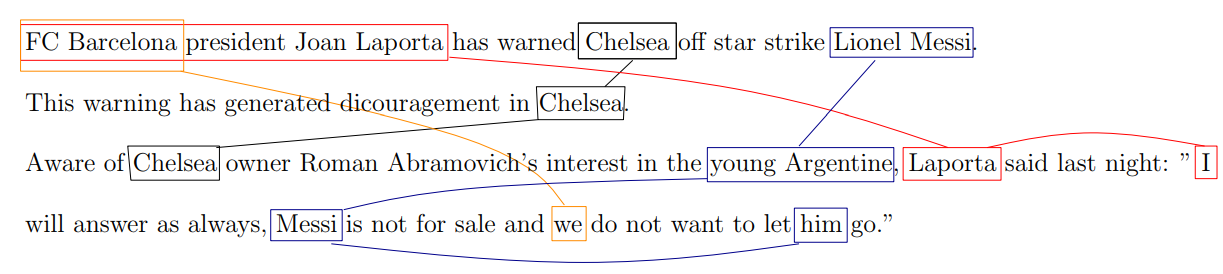

### Reference
1. [Slides](http://www.cs.upc.edu/~ageno/anlp/coreference.pdf)

## Official Python Client

In [2]:
!pip install stanford-corenlp

In [27]:
from corenlp import CoreNLPClient

In [38]:
annotators = "tokenize ssplit pos lemma ner parse depparse".split()
client = CoreNLPClient(start_server=False, annotators=annotators, output_format='json')

In [39]:
ann = client.annotate(summary)

In [45]:
for parsed in ann['sentences']:
    for k, v in parsed.items():
        print(k)
        print(v)
        print()

index
0

parse
(ROOT
  (S
    (NP (PRP We))
    (VP (VBP show)
      (SBAR
        (S
          (NP
            (NP (DT a) (NN representation))
            (PP (IN of)
              (NP (NNP Quantum) (NNP Computers))))
          (VP (VBZ defines)
            (NP
              (NP (NNP Quantum) (NNP Turing) (NNPS Machines))
              (PP (IN with)
                (S
                  (VP (VBN associated)
                    (NP (NNP Quantum) (NNP Grammars))))))))))
    (. .)))

basicDependencies
[{'dep': 'ROOT', 'governor': 0, 'governorGloss': 'ROOT', 'dependent': 2, 'dependentGloss': 'show'}, {'dep': 'nsubj', 'governor': 2, 'governorGloss': 'show', 'dependent': 1, 'dependentGloss': 'We'}, {'dep': 'det', 'governor': 4, 'governorGloss': 'representation', 'dependent': 3, 'dependentGloss': 'a'}, {'dep': 'nsubj', 'governor': 8, 'governorGloss': 'defines', 'dependent': 4, 'dependentGloss': 'representation'}, {'dep': 'case', 'governor': 7, 'governorGloss': 'Computers', 'dependent': 5, 'de